# **SETUP**

## **Libraries**

In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.5.0
Hub version: 0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


## **Mounting google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/MyDrive/ /mydrive
!ls /mydrive

## **Cloning and building the Darknet**

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15072, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 15072 (delta 0), reused 1 (delta 0), pack-reused 15069
Receiving objects: 100% (15072/15072), 13.46 MiB | 24.31 MiB/s, done.
Resolving deltas: 100% (10244/10244), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:935:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1136:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
  

## **Download pretrained yolo v3 weights**

In [ ]:
# get yolov3 pretrained coco dataset weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-06-10 15:42:58--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  37.7MB/s    in 6.7s    

2021-06-10 15:43:05 (35.1 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload()
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file
def download(path):
  from google.colab import files
  files.download(path)

# **Training a Custom YOLOv3 Object Detector**

## **Moving Custom Dataset Into Cloud**


In [ ]:
# this is where my zip is stored (I created a yolov3 folder where I will get my required files from)
!ls /mydrive/CNN/yolov3

backup		   images.zip  obj.names	yolov3_custom.cfg
generate_train.py  obj.data    test-images.zip


In [ ]:
# copy the .zip file into the root directory of cloud VM
!cp /mydrive/CNN/yolov3/images.zip ../

In [ ]:
# unzip the zip file and its contents should now be in /darknet/data/obj
!unzip ../images.zip -d data/obj

Archive:  ../images.zip
  inflating: data/obj/deer_000001.jpg  
  inflating: data/obj/deer_000001.txt  
  inflating: data/obj/deer_000002.jpg  
  inflating: data/obj/deer_000002.txt  
  inflating: data/obj/deer_000003.jpg  
  inflating: data/obj/deer_000003.txt  
  inflating: data/obj/deer_000004.jpg  
  inflating: data/obj/deer_000004.txt  
  inflating: data/obj/deer_000005.jpg  
  inflating: data/obj/deer_000005.txt  
  inflating: data/obj/deer_000007.jpg  
  inflating: data/obj/deer_000007.txt  
  inflating: data/obj/deer_000008.jpg  
  inflating: data/obj/deer_000008.txt  
  inflating: data/obj/deer_000009.jpg  
  inflating: data/obj/deer_000009.txt  
  inflating: data/obj/deer_000010.jpg  
  inflating: data/obj/deer_000010.txt  
  inflating: data/obj/deer_000011.jpg  
  inflating: data/obj/deer_000011.txt  
  inflating: data/obj/deer_000012.jpg  
  inflating: data/obj/deer_000012.txt  
  inflating: data/obj/deer_000014.jpg  
  inflating: data/obj/deer_000014.txt  
  inflating: dat

## **Configuring Files for Training**

I) cfg file

In [ ]:
# upload the custom .cfg back to cloud VM from Google Drive
!cp /mydrive/CNN/yolov3/yolov3_custom.cfg ./cfg

II) obj.names and obj.data

In [ ]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp /mydrive/CNN/yolov3/obj.names ./data
!cp /mydrive/CNN/yolov3/obj.data  ./data

III) train.txt

In [ ]:
# upload the generate_train.py script to cloud VM from Google Drive
!cp /mydrive/CNN/yolov3/generate_train.py ./

In [ ]:
!python generate_train.py

In [ ]:
!ls data/

9k.tree     eagle.jpg	 imagenet.labels.list	   obj.data	     scream.jpg
coco9k.map  giraffe.jpg  imagenet.shortnames.list  obj.names	     train.txt
coco.names  goal.txt	 labels			   openimages.names  voc.names
dog.jpg     horses.jpg	 obj			   person.jpg


## **Download pre-trained weights for the convolutional layers.**

In [ ]:
# upload pretrained convolutional layer weights
!wget http://pjreddie.com/media/files/darknet53.conv.74

URL transformed to HTTPS due to an HSTS policy
--2021-06-08 23:46:24--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  38.0MB/s    in 4.5s    

2021-06-08 23:46:29 (34.2 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



## **Training**

In [ ]:
# train your custom detector
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show

/bin/bash: ./darknet: No such file or directory


## **Continue to train after problems with Colab (optional)**

In [ ]:
!ls /mydrive/CNN/yolov3/backup/

yolov3_custom_1000.weights  yolov3_custom_4000.weights
yolov3_custom_2000.weights  yolov3_custom_final.weights
yolov3_custom_3000.weights  yolov3_custom_last.weights


In [ ]:
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/CNN/yolov3/backup/yolov3_custom_last.weights -dont_show

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.879294), count: 1, class_loss = 0.000000, iou_loss = 0.005876, total_loss = 0.005877 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.871325), count: 1, class_loss = 0.020877, iou_loss = 0.006725, total_loss = 0.027602 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.808115), count: 6, class_loss = 0.128913, iou_loss = 0.163467, total_loss = 0.292380 
 total_bbox = 197078, rewritten_bbox = 0.141568 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.865318), count: 3, class_loss = 0.016141, iou_loss = 0.028756, total_loss = 0.044896 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.777579), count: 1, class_loss = 0.000004, iou_loss = 0.023152, total_loss = 0.023156 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 

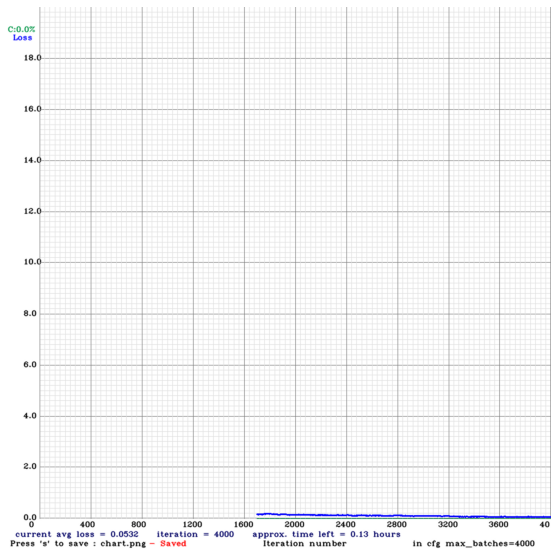

In [ ]:
imShow("chart.png")

# **Testing a Custom YOLOv3 Object Detector**


In [ ]:
# need to set our custom cfg to test mode
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3_custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3_custom.cfg
%cd ..

/content/darknet/cfg
/content/darknet


 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595

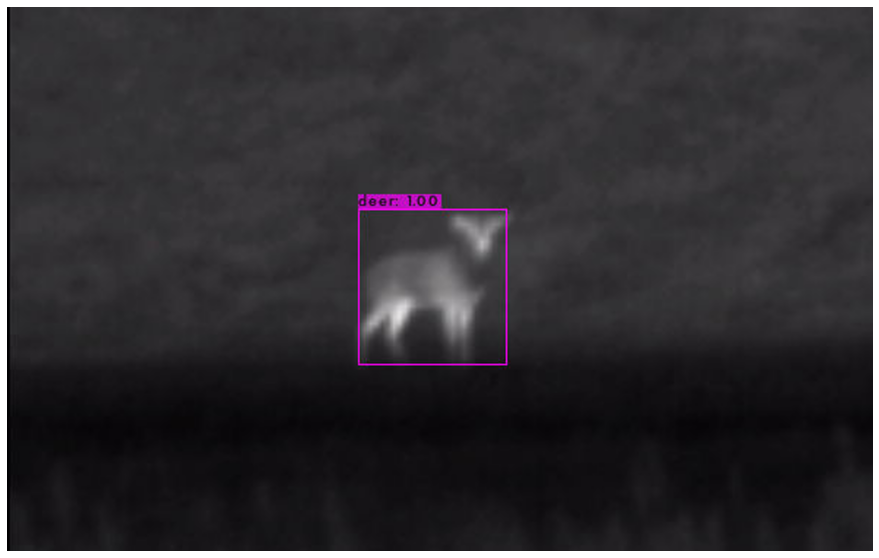

In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /mydrive/CNN/yolov3/backup/yolov3_custom_final.weights /mydrive/CNN/images/0021.jpg -thresh 0.3
imShow('predictions.jpg')

# **Calculating mAP (AP50)**


Cleaning data/obj directory

In [ ]:
!rm data/obj/*

In [ ]:
# copy the .zip file into the root directory of cloud VM
!cp /mydrive/CNN/yolov3/test-images.zip ../

In [ ]:
# unzip the zip file and its contents should now be in /darknet/data/obj
!unzip ../test-images.zip -d data/obj

Archive:  ../test-images.zip
  inflating: data/obj/deer_000006.jpg  
  inflating: data/obj/deer_000006.txt  
  inflating: data/obj/deer_000013.jpg  
  inflating: data/obj/deer_000013.txt  
  inflating: data/obj/deer_000019.jpg  
  inflating: data/obj/deer_000019.txt  
  inflating: data/obj/deer_000025.jpg  
  inflating: data/obj/deer_000025.txt  
  inflating: data/obj/deer_000026.jpg  
  inflating: data/obj/deer_000026.txt  
  inflating: data/obj/deer_000034.jpg  
  inflating: data/obj/deer_000034.txt  
  inflating: data/obj/deer_000047.jpg  
  inflating: data/obj/deer_000047.txt  
  inflating: data/obj/deer_000051.jpg  
  inflating: data/obj/deer_000051.txt  
  inflating: data/obj/deer_000054.jpg  
  inflating: data/obj/deer_000054.txt  
  inflating: data/obj/deer_000071.jpg  
  inflating: data/obj/deer_000071.txt  
  inflating: data/obj/deer_000082.jpg  
  inflating: data/obj/deer_000082.txt  
  inflating: data/obj/deer_000090.jpg  
  inflating: data/obj/deer_000090.txt  
  inflating

In [ ]:
# upload the generate_train.py script to cloud VM from Google Drive
!cp /mydrive/CNN/yolov3/generate_test.py ./

In [ ]:
!python generate_test.py

In [ ]:
# yolo v3 validation
!./darknet detector map data/obj.data cfg/yolov3_custom.cfg /mydrive/CNN/yolov3/backup/yolov3_custom_final.weights

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595